In [28]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/K01_Strains_AMLN30weeks_Kupffer_RNA/'
dataDirectory = '/home/h1bennet/strains/data/RNA/AMLN_30week_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferNASH/
     
Ty re-ran the analysis filtering hepatocyte biased genes that were contaminating some of our samples. These new results are stored at the following locations:
    
    /home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM/rnaDiff_filter_join
    /home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM/rnaQuan/filterT_join.txt
 

# Import differential gene files for examination and plotting

## Write differential genes to list for metascape

In [32]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [33]:
strains = ['aj', 'balb', 'c57']
log2fc = 1
padj = 0.05
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaQuan/filterT_join.txt'

In [34]:
gene_list_dict ={}

In [35]:
for strain in strains:
    # initialize gene lists
    g_intersect = set()
    g_union = set()
    for i in glob.glob(diffDir+strain+'*NASH.vs.*NASH*.txt'):
        print(i)
        df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)

        # select differential genes
        # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
        sig_genes = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
        
        # add to sets
        if len(g_union) == 0:
            g_union = set(sig_genes)
            g_intersect = set(sig_genes)
        else:
            g_union = g_union.union(sig_genes)
            g_intersect = g_intersect.intersection(sig_genes)
        
        # print('union set length:', print(len(g_union)))
        # print('intersection set length:', print(len(g_intersect)))
    
    # after getting union and intersection sets add to dict
    gene_list_dict[strain+'_union'] = list(g_union)
    gene_list_dict[strain+'_intersection'] = list(g_intersect)
        

/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/aj_NASH.vs.balbcj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/aj_NASH.vs.c57bl6j_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/balbcj_NASH.vs.aj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/balbcj_NASH.vs.c57bl6j_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/c57bl6j_NASH.vs.balbcj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_KC_only/rnaDiff_filter_join/c57bl6j_NASH.vs.aj_NASH.scatter.txt


In [36]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_nash_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()


aj_union
605 genes
aj_intersection
43 genes
balb_union
684 genes
balb_intersection
64 genes
c57_union
520 genes
c57_intersection
162 genes


# Plot potential nichenet ligands

In [9]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Read in raw expression values

In [10]:
tpm_mat = pd.read_csv(rnaQuan,
                      sep='\t', index_col=0)
tpm_mat = tpm_mat.loc[:, tpm_mat.columns.str.contains('NASH')]
tpm_mat.index = tpm_mat.index.rename('gene')

Read in nichenet ligands

In [11]:
ligands = pd.read_csv('/home/h1bennet/data/gene_lists/nichenet_ligands.txt',
                      sep='\t')['x'].str.capitalize().tolist()
ligands[:5]

['Cxcl1', 'Cxcl2', 'Cxcl3', 'Cxcl5', 'Ppbp']

### Intersection gene set

In [12]:
act = []
for key in gene_list_dict.keys():
    if 'intersection' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)

In [13]:
tpm_mat.columns

Index(['aj_NASH_rep1', 'aj_NASH_rep2', 'aj_NASH_rep3', 'aj_NASH_rep4',
       'balbcj_NASH_rep5', 'balbcj_NASH_rep6', 'balbcj_NASH_rep7',
       'c57bl6j_NASH_rep1', 'c57bl6j_NASH_rep2', 'c57bl6j_NASH_rep3',
       'c57bl6j_NASH_rep4'],
      dtype='object')

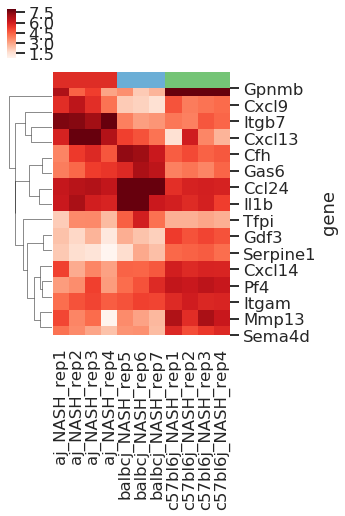

In [14]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,6),
    yticklabels=1,
    xticklabels=1)

plt.savefig('./figures/diff_genes_intersection_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

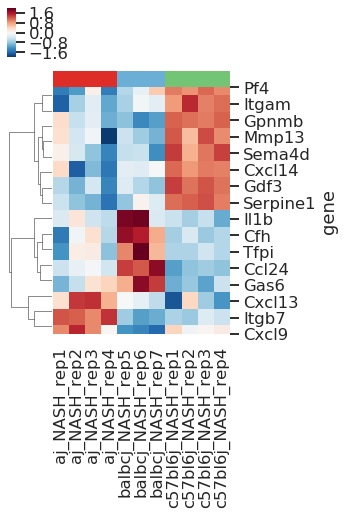

In [15]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,6),
    yticklabels=1,
    xticklabels=1)

plt.savefig('./figures/diff_genes_intersection_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

## Look at union gene set

In [16]:
act = []
for key in gene_list_dict.keys():
    if 'union' in key:
        act.extend(gene_list_dict[key])

act = set(act)
# overlap with ligands
act_ligands = act.intersection(ligands)

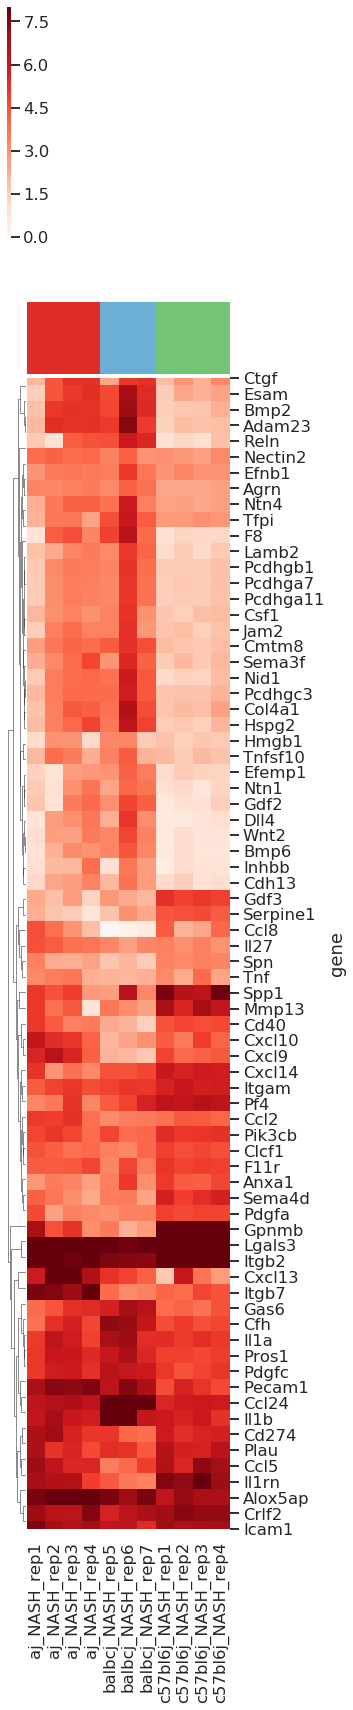

In [17]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,28),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

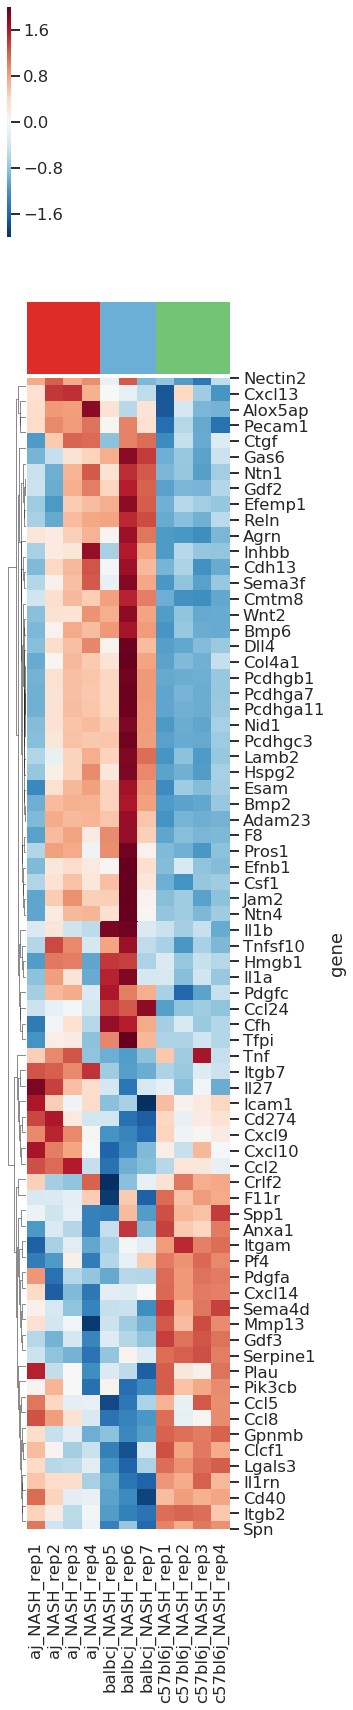

In [18]:
sns.clustermap(
    np.log2(tpm_mat.loc[act_ligands]+1),
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#de2d26', '#de2d26', '#de2d26', '#de2d26',
                  '#6baed6', '#6baed6', '#6baed6',
                  '#74c476', '#74c476', '#74c476', '#74c476'],
    figsize=(4,28),
    yticklabels=1)

plt.savefig('./figures/diff_genes_union_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

# View single gene expression barplots

In [29]:
groups = [[0,1,2,3],
          [4,5,6],
          [7,8,9,10]]

group_labels = ['AJ Kupffer AMLN 30 weeks',
                'Balb/cJ Kupffer AMLN 30 weeks',
                'C57BL/6J Kupffer AMLN 30 weeks']

colors = ['#a50f15',
          '#08519c',
          '#006d2c']

legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

In [30]:
tpm_mat.columns

Index(['aj_NASH_rep1', 'aj_NASH_rep2', 'aj_NASH_rep3', 'aj_NASH_rep4',
       'balbcj_NASH_rep5', 'balbcj_NASH_rep6', 'balbcj_NASH_rep7',
       'c57bl6j_NASH_rep1', 'c57bl6j_NASH_rep2', 'c57bl6j_NASH_rep3',
       'c57bl6j_NASH_rep4'],
      dtype='object')

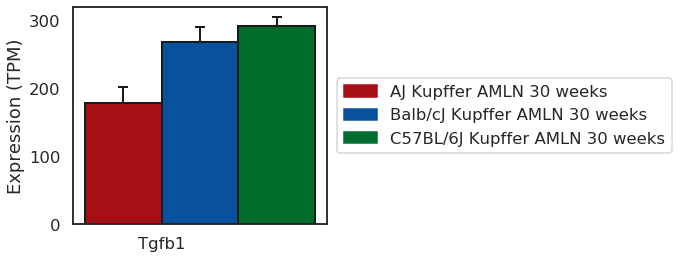

In [31]:
gene = 'Tgfb1'

fig, axs = plt.subplots(1, 2,
                       figsize=(10, 4))

gene_list_bar_plot([gene],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

plt.savefig('./figures/'+gene+'_tpm_barplot.png', bbox_inches='tight')

# Metascape analysis

In [39]:
def plot_top_terms_metascape(metascape_path, n_terms, color='#969696', ax=None):
    # read in df
    df = pd.read_excel(metascape_path,
                   sheet_name='Enrichment')
    df = df.loc[df['GroupID'].str.contains('Summary'), :]
    df = df.sort_values('LogP', ascending=True)
    
    # make plot
    if ax==None:
        fig, ax = plt.subplots(figsize=(4,4))

    ax.barh(range(n_terms),
           -df['LogP'].iloc[:n_terms],
           color=color,
           edgecolor='k')


    ax.set_yticks(range(n_terms))
    ax.set_yticklabels(df['Description'].iloc[:n_terms]);
    ax.set_ylim([n_terms-0.5,-0.5]);
    ax.set_xlabel('-log10(p-value)');

In [42]:
paths = np.sort(glob.glob('./gene_lists/**/metascape_result.xlsx'))
colors = ['#a50f15', '#08519c', '#006d2c']

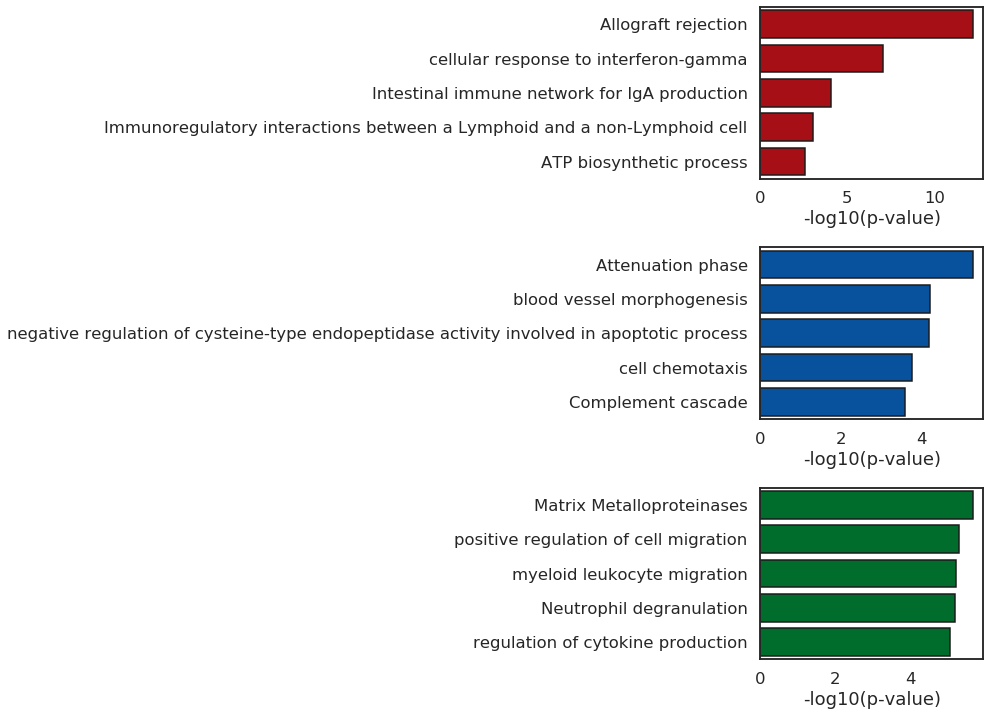

In [43]:
fig, axs = plt.subplots(3,1,figsize=(4,12))
plt.subplots_adjust(hspace=0.4)

for path, color, ax in zip(paths, colors, axs.flatten()):
    plot_top_terms_metascape(path, n_terms=5, color=color, ax=ax)
    